<a href="https://colab.research.google.com/github/sp8rks/MaterialsInformatics/blob/main/worked_examples/2_pt_statistics_example/2pt_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What are 2-Point Spatial Correlations (also called 2-Point Statistics)?
This example computes both periodic and non-periodic 2-point spatial correlations (also referred to as 2-point stats or auto-correlations and cross-correlations) for a checkerboard microstructure. This is a simple example to demonstrate how spatial correlations capture features seen in the original microstructure. More technical details about 2-point statistics are in the theory section.

taken from http://pymks.org/en/stable/rst/notebooks/checkerboard.html

#### Video

https://www.youtube.com/watch?v=FanPB2sNNY8&list=PLL0SWcFqypCl4lrzk1dMWwTUrzQZFt7y0&index=14& (Two-point statistics)

## Setup


In [32]:
#skip this cell if running locally and not in google colab
#!pip install pymks
#!pip install PIL
#from google.colab import drive
#drive.mount('/content/drive/')
#%cd /content/drive/My Drive/teaching/5540-6640 Materials Informatics/MaterialsInformatics/worked_examples/2_pt_statistics_example

In [33]:
import numpy as np
from sklearn.pipeline import Pipeline

from pymks import (
    generate_checkerboard,
    plot_microstructures,
    PrimitiveTransformer,
    TwoPointCorrelation
)

In [34]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Start with a 8x8 microstructure as a useful tool for seeing correlations

In [35]:
x_data = generate_checkerboard(
    size=(21 * 8, 21 * 8),
    square_shape=(21, 21)
).persist()

(1, 168, 168)


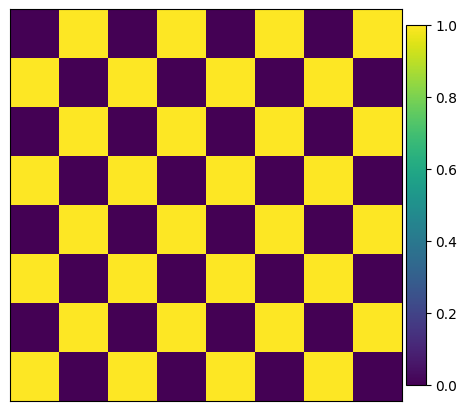

In [36]:
plot_microstructures(x_data[0])
print(x_data.shape)

or we can do it on any generic image we'd like

(280, 280)
(1, 280, 280)


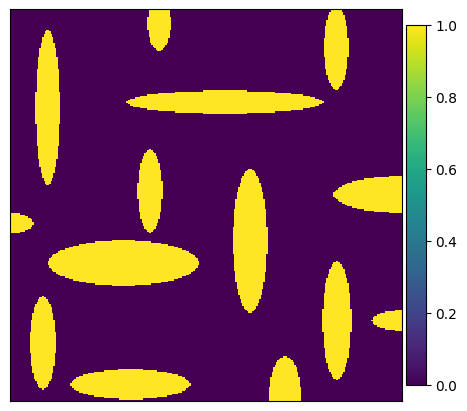

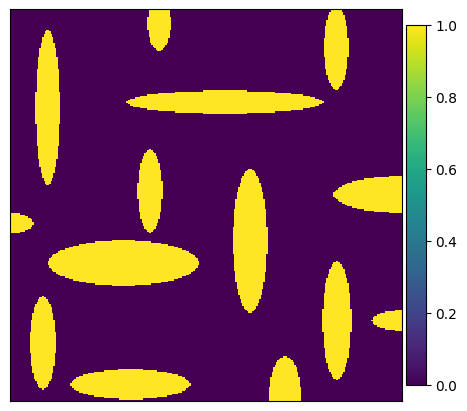

In [37]:
from PIL import Image

# open method used to open different extension image file
im = Image.open(r"custom3.jpg")

# This method will show image in any image viewer
#im.show()

# asarray() class is used to convert
# PIL images into NumPy arrays
numpydata = np.asarray(im)
thresh = 200
fn = lambda x : 255 if x > thresh else 0
r = im.convert('L').point(fn, mode='1')
numpydata = np.asarray(r)
print(numpydata.shape)
x_data=numpydata
y = np.expand_dims(x_data, axis=0)
print(y.shape)
x_data = y
plot_microstructures(x_data[0])

## Compute Periodic 2-Point Statistics
Compute the periodic 2-points stats using the TwoPointCorrelation class. The periodic_boundary argument is set to True. To compute 2-point stats first discretize the microstructure using a chosen basis using a PrimitiveTransformer with n_state equal to 2. The PrimitiveTransformer and the TwoPointCorrelation are combined into a Scikit-learn pipeline to generate a model. The transform method executes the pipeline as this is not a model that requires a predict step to use.

Periodic 2-Point statistics makes an assumption that the microstructure is repeating consistently.

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin

class FitFlagWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, transformer):
        self.transformer = transformer

    def fit(self, X, y=None):
        if hasattr(self.transformer, "fit"):
            self.transformer.fit(X, y)
        self.is_fitted_ = True
        self.n_features_in_ = X.shape[1] if X.ndim >= 2 else 1
        return self

    def transform(self, X):
        return self.transformer.transform(X)

model = Pipeline(steps=[
    ('discretize', FitFlagWrapper(PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0))),
    ('correlations', FitFlagWrapper(TwoPointCorrelation(
        periodic_boundary=True,
        cutoff=x_data.shape[1],
        correlations=[[0, 0], [1, 1], [0, 1]]
    )))
])

model.fit(x_data)
x_stats = model.transform(x_data).persist()
print(x_stats.shape)


(1, 279, 279, 3)


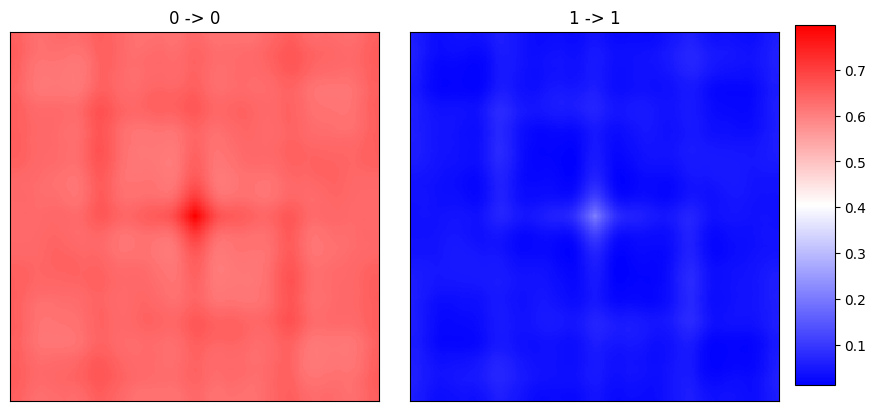

In [39]:
plot_microstructures(x_stats[0, :, :, 0], x_stats[0, :, :, 1], titles=['0 -> 0', '1 -> 1'], cmap='bwr');


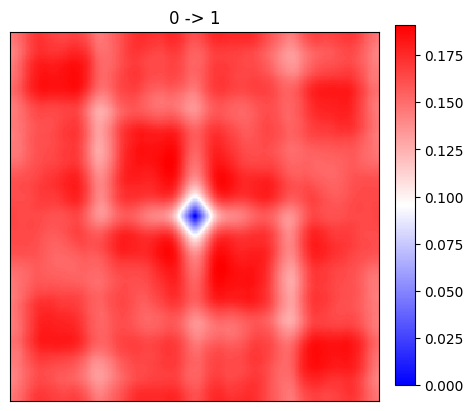

In [40]:
plot_microstructures(x_stats[0, :, :, 2], titles=['0 -> 1'], cmap='bwr');


In [41]:
center = x_stats.shape[1] // 2

print('Volume fraction of 0 -> 0: ', np.allclose(x_stats[0, center, center, 0], 0.5))
print('Volume fraction of 0 -> 1: ', np.allclose(x_stats[0, center, center, 2], 0))

Volume fraction of 0 -> 0:  dask.array<all-aggregate, shape=(), dtype=bool, chunksize=(), chunktype=numpy.ndarray>
Volume fraction of 0 -> 1:  dask.array<all-aggregate, shape=(), dtype=bool, chunksize=(), chunktype=numpy.ndarray>


## Compute Non-Periodic 2-Point Statistics
Compute the non-periodic 2-point statistics for the microstructure, but with non-periodic statistics by setting the periodic_boundary=False.

Non-Periodic 2-Point statistics is useful for when you want to analyze a microstructure that doesn't repeat consistently.

In [42]:
model = Pipeline(steps=[
    ('discretize', PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ('correlations', TwoPointCorrelation(
        periodic_boundary=False,
        cutoff=x_data.shape[1],
        correlations=[[0, 0], [1, 1], [0, 1]]
    ))
])
x_stats = model.fit_transform(x_data).persist()
x_stats.shape


(1, 279, 279, 3)

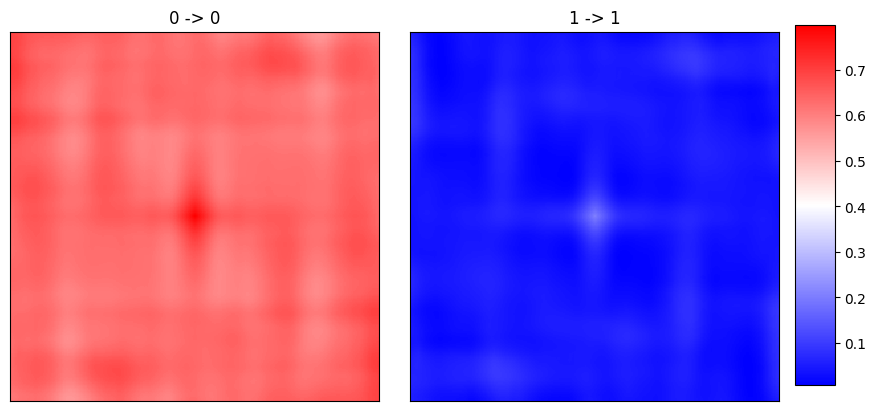

In [43]:
plot_microstructures(x_stats[0, :, :, 0], x_stats[0, :, :, 1], titles=['0 -> 0', '1 -> 1'], cmap='bwr');


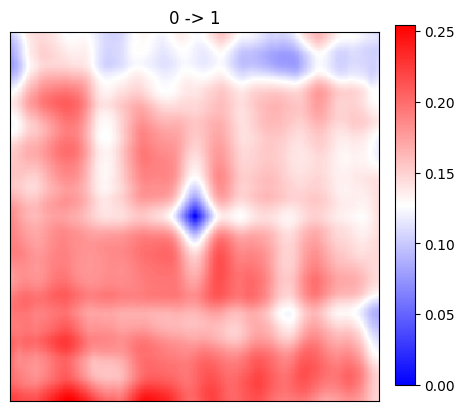

In [44]:
plot_microstructures(x_stats[0, :, :, 2], titles=['0 -> 1'], cmap='bwr');


In [45]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

print('Volume fraction of black phase', x_stats[0, center, center, 0].compute())
print('Volume fraction of white phase', x_stats[0, center, center, 1].compute())

Volume fraction of black phase 0.797627551020407
Volume fraction of white phase 0.20237244897959164


# Try it yourself!

- There are three images of real grain boundaries in the 2 point statistics example folder
- After importing the image, visually plot the microstructures of each photo similar to what was done above
- Play around with the threshhold and see what gives a good resolution
- What would you expect to work best for these microstructures? Periodic or Non-Periodic?
- Play around with the threshold after plotting the Periodic/Non-Periodic graphs. How does this change the visualized statistics?


In [46]:
# Code here
